PCA visualization:


PCA Explained Variance Ratio: [0.85274294 0.13900195]

Top 5 Potential Outliers:
           alt   mach  speed_ias  speed_tas   Distance  Cluster
20014  32250.0  0.624      720.0      460.0  11.968155        1
27485  32000.0  0.636      596.0      462.0   8.670540        1
16706  41000.0  0.336      596.0      492.0   8.442333        1
18282   8250.0  0.128      572.0      284.0   8.249596        0
25726  40975.0  0.104      564.0      486.0   7.581097        1


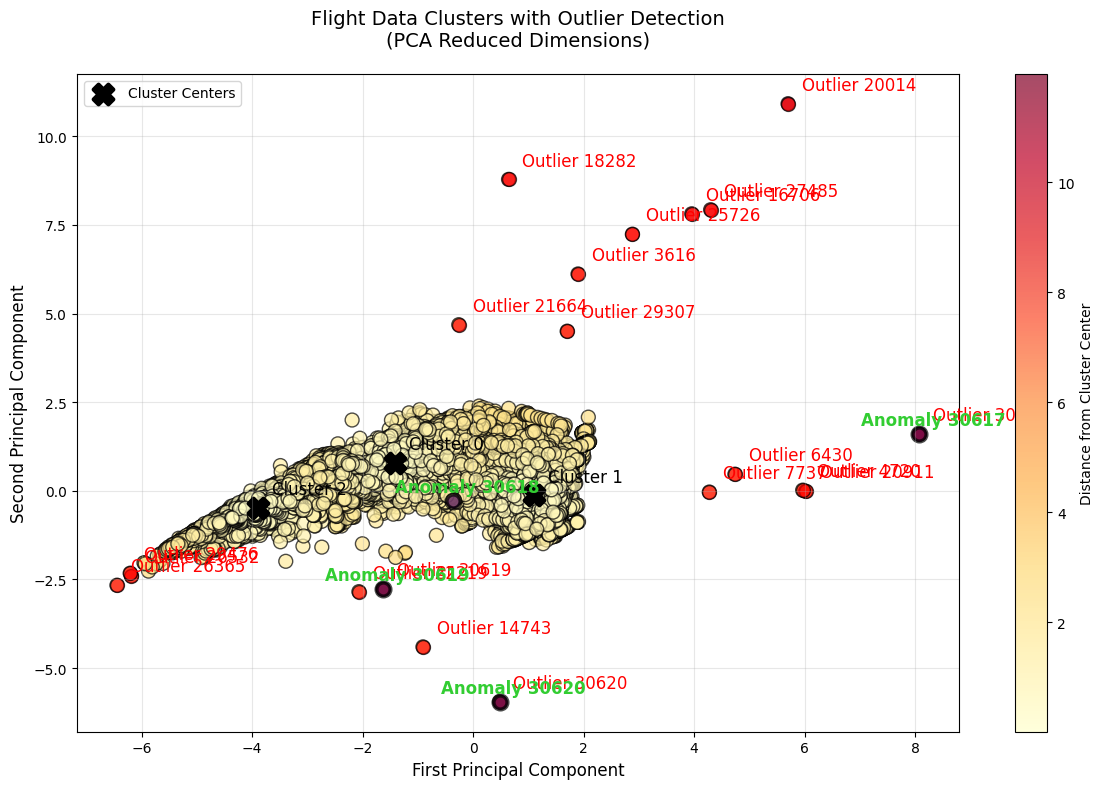

In [49]:
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Create extreme aviation-specific anomalies
def create_extreme_aviation_anomaly(base_flight, anomaly_type, data_stats):
    anomaly = base_flight.copy()
    
    if anomaly_type == 'speed_violation':
        anomaly['speed_tas'] = 800  # Extreme speed for commercial aircraft
        anomaly['speed_ias'] = 400  # Very high IAS
        anomaly['mach'] = 2.0      # Supersonic
    elif anomaly_type == 'altitude_pressure':
        anomaly['alt'] = 45000     # Above typical service ceiling
        anomaly['mach'] = 0.2      # Too slow for high altitude
    elif anomaly_type == 'vertical_performance':
        anomaly['speed_ias'] = 150   # Too slow for normal flight
        anomaly['alt'] = 38000       # High altitude
        anomaly['mach'] = 0.3        # Too slow for altitude
    elif anomaly_type == 'combined':
        anomaly['alt'] = 42000
        anomaly['speed_tas'] = 750
        anomaly['speed_ias'] = 50    # Impossible IAS/TAS relationship
        
    return anomaly

# Generate extreme aviation anomalies
def generate_aviation_anomalies(data, num_anomalies=5):
    anomalies = []
    data_stats = {col: {'mean': data[col].mean(), 'std': data[col].std()} 
                 for col in data.columns}
    
    anomaly_types = [
        'speed_violation',
        'altitude_pressure',
        'vertical_performance',
        'combined'
    ]
    
    for anomaly_type in anomaly_types:
        base_flight = data.sample(n=1).iloc[0]
        anomaly = create_extreme_aviation_anomaly(base_flight, anomaly_type, data_stats)
        anomalies.append(anomaly)
    
    anomalies_df = pd.DataFrame(anomalies).reset_index(drop=True)
    combined_data = pd.concat([data, anomalies_df], ignore_index=True)
    
    labels = np.zeros(len(combined_data))
    labels[len(data):] = 1  # Mark anomalies with label '1'
    
    return combined_data, labels, anomalies_df

# Read and process JSON data
with open('data.json', 'r') as file:
    data = json.load(file)
    if isinstance(data, dict):
        data = [data]

# Extract relevant features
features = ['alt', 'mach', 'speed_ias', 'speed_tas']
df = pd.DataFrame(data)[features]

# Convert to numeric, handling any non-numeric values
for col in features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with missing values
df = df.dropna()

# Step 1: Generate anomalies and combine data
combined_data, labels, anomalies_df = generate_aviation_anomalies(df, num_anomalies=5)

# Step 2: Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_data[['alt', 'speed_tas', 'speed_ias', 'mach']])

# Step 3: Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Step 4: Apply K-means clustering
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Step 5: Calculate distances from cluster centers (after combining data and anomalies)
centers_transformed = pca.transform(kmeans.cluster_centers_)
distances = np.min([np.linalg.norm(pca_result - center, axis=1) 
                   for center in centers_transformed], axis=0)

# Step 6: Create the plot with white background
plt.figure(figsize=(12, 8))
plt.style.use('default')

# Step 7: Create scatter plot with distances as colors
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1],
                     c=distances,  # Color by distance
                     cmap='YlOrRd',  # Yellow to Orange to Red colormap
                     s=100,
                     alpha=0.7,
                     edgecolor='black',  # Black outline for points
                     linewidth=1)  # Default linewidth

# Step 8: Plot cluster centers
plt.scatter(centers_transformed[:, 0], centers_transformed[:, 1],
           c='black', marker='X', s=200, linewidth=3,
           label='Cluster Centers')

# Add cluster labels
for i in range(n_clusters):
    center = centers_transformed[i]
    plt.annotate(f'Cluster {i}',
                xy=(center[0], center[1]),
                xytext=(10, 10),
                textcoords='offset points',
                fontsize=12,
                color='black')

# Step 9: Add title and labels
plt.title('Flight Data Clusters with Outlier Detection\n(PCA Reduced Dimensions)', 
          fontsize=14, pad=20)
plt.xlabel('First Principal Component', fontsize=12)
plt.ylabel('Second Principal Component', fontsize=12)

# Step 10: Add the colorbar using the scatter plot
cbar = plt.colorbar(scatter, label='Distance from Cluster Center')
cbar.ax.set_ylabel('Distance from Cluster Center', fontsize=10)

# Step 11: Add grid
plt.grid(True, alpha=0.3)

# Step 12: Print explained variance ratio
print("\nPCA Explained Variance Ratio:", pca.explained_variance_ratio_)

# Step 13: Print summary of points furthest from their cluster centers (potential outliers)
combined_data['Distance'] = distances
combined_data['Cluster'] = clusters
print("\nTop 5 Potential Outliers:")
print(combined_data.nlargest(5, 'Distance')[features + ['Distance', 'Cluster']])

# Step 14: Visualize potential outliers in red
outlier_positions = combined_data.nlargest(20, 'Distance').index  # Top 20 outliers
scatter_outliers = plt.scatter(pca_result[outlier_positions, 0], 
                               pca_result[outlier_positions, 1],
                               c='red', s=100, alpha=0.7, edgecolor='black', linewidth=1)

# Add labels for the outliers
for idx, row in combined_data.nlargest(20, 'Distance').iterrows():
    plt.annotate(f'Outlier {idx}',
                 xy=(pca_result[idx, 0], pca_result[idx, 1]),
                 xytext=(10, 10),
                 textcoords='offset points',
                 fontsize=12,
                 color='red')

# Step 15: Label anomalies with the same color as the other points and thicker outline for anomaly points
anomaly_positions = combined_data.index[len(df):]  # Only the anomalies added
for idx in anomaly_positions:
    plt.scatter(pca_result[idx, 0], pca_result[idx, 1],
                c=distances[idx], s=100, alpha=0.7, 
                edgecolor='black', linewidth=3)  # Black outline for anomaly points
    plt.annotate(f'Anomaly {idx}',
                 xy=(pca_result[idx, 0], pca_result[idx, 1]),
                 xytext=(10, 10),
                 textcoords='offset points',
                 fontsize=12,
                 color='limegreen', weight='bold', 
                 ha='center', va='center')  # No outline for text


# Show legend
plt.legend()

plt.tight_layout()
plt.show()


#

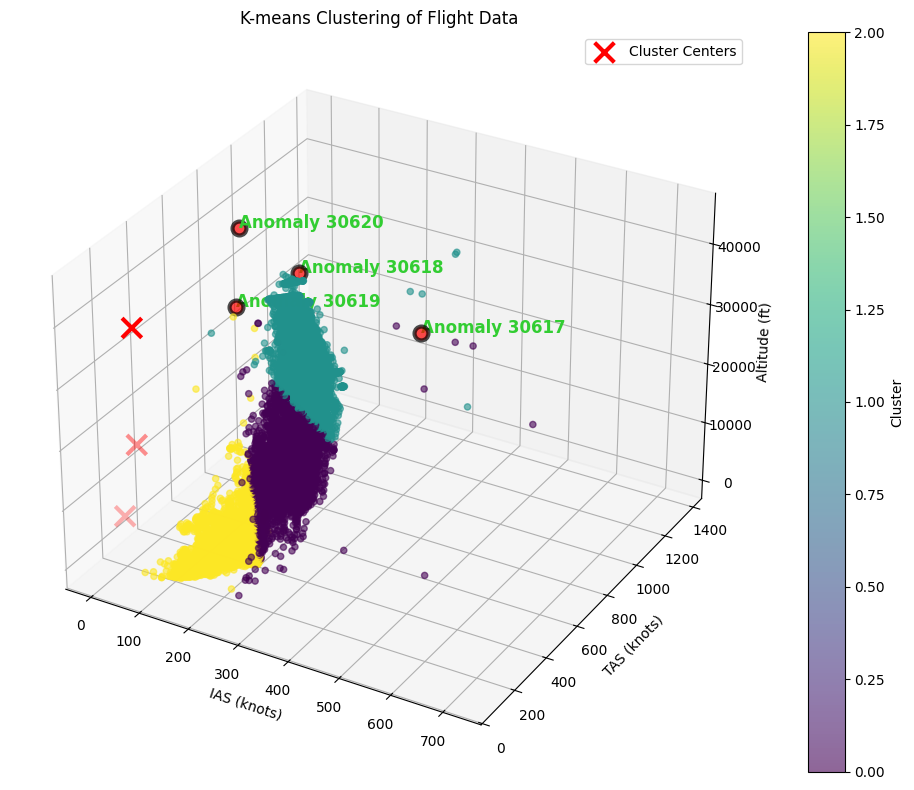


Cluster Summary Statistics:

Cluster 0:
                alt         mach    speed_ias    speed_tas  Cluster
count   5712.000000  5712.000000  5712.000000  5712.000000   5712.0
mean   15701.527486     0.554696   273.769608   352.262430      0.0
std     5757.442707     0.087957    26.592283    50.451326      0.0
min      175.000000     0.104000   189.000000   106.000000      0.0
25%    11018.750000     0.468000   250.000000   302.000000      0.0
50%    15950.000000     0.568000   273.000000   360.000000      0.0
75%    20356.250000     0.628000   296.000000   394.000000      0.0
max    41000.000000     0.852000   720.000000   500.000000      0.0

Cluster 1:
                alt          mach     speed_ias     speed_tas  Cluster
count  20043.000000  20043.000000  20043.000000  20043.000000  20043.0
mean   35081.241581      0.795804    269.759018    467.963329      1.0
std     4172.501394      0.042045     19.310831     24.382973      0.0
min    20475.000000      0.352000     92.000000    

In [50]:
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to generate extreme aviation anomalies
def create_extreme_aviation_anomaly(base_flight, anomaly_type, data_stats):
    """Create more extreme aviation-specific anomalies"""
    anomaly = base_flight.copy()
    
    if anomaly_type == 'speed_violation':
        anomaly['speed_tas'] = 800  # Extreme speed for commercial aircraft
        anomaly['speed_ias'] = 400  # Very high IAS
        anomaly['mach'] = 2.0      # Supersonic
        
    elif anomaly_type == 'altitude_pressure':
        anomaly['alt'] = 45000      # Above typical service ceiling
        anomaly['mach'] = 0.2       # Too slow for high altitude
        
    elif anomaly_type == 'vertical_performance':
        anomaly['speed_ias'] = 150  # Too slow for normal flight
        anomaly['alt'] = 38000      # High altitude
        anomaly['mach'] = 0.3       # Too slow for altitude
    
    elif anomaly_type == 'combined':
        anomaly['alt'] = 42000
        anomaly['speed_tas'] = 750
        anomaly['speed_ias'] = 50   # Impossible IAS/TAS relationship
        
    return anomaly

def generate_aviation_anomalies(data, num_anomalies=5):
    """Generate more extreme aviation-specific anomalies"""
    anomalies = []
    
    data_stats = {col: {'mean': data[col].mean(), 'std': data[col].std()} 
                 for col in data.columns}
    
    anomaly_types = [
        'speed_violation',
        'altitude_pressure',
        'vertical_performance',
        'combined'
    ]
    
    for anomaly_type in anomaly_types:
        base_flight = data.sample(n=1).iloc[0]
        anomaly = create_extreme_aviation_anomaly(base_flight, anomaly_type, data_stats)
        anomalies.append(anomaly)
    
    anomalies_df = pd.DataFrame(anomalies).reset_index(drop=True)
    combined_data = pd.concat([data, anomalies_df], ignore_index=True)
    
    labels = np.zeros(len(combined_data))
    labels[len(data):] = 1
    
    return combined_data, labels, anomalies_df

# Read and process JSON data
with open('data.json', 'r') as file:
    data = json.load(file)
    if isinstance(data, dict):  # If single record
        data = [data]

# Extract relevant features
features = ['alt', 'mach', 'speed_ias', 'speed_tas']
df = pd.DataFrame(data)[features]

# Convert to numeric, handling any non-numeric values
for col in features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with missing values
df = df.dropna()

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)

# Train K-means model (using 3 clusters as an example)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Create 3D visualization
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the points
scatter = ax.scatter(df['speed_ias'], 
                     df['speed_tas'], 
                     df['alt'],
                     c=clusters, 
                     cmap='viridis',
                     alpha=0.6)

# Add labels and title
ax.set_xlabel('IAS (knots)')
ax.set_ylabel('TAS (knots)')
ax.set_zlabel('Altitude (ft)')
plt.title('K-means Clustering of Flight Data')

# Add colorbar
plt.colorbar(scatter, label='Cluster')

# Add cluster centers
centers = scaler.inverse_transform(kmeans.cluster_centers_)
ax.scatter(centers[:, 1], centers[:, 2], centers[:, 0], 
           c='red', marker='x', s=200, linewidth=3, 
           label='Cluster Centers')

# Generate anomalies and add to the dataset
combined_data, labels, anomalies_df = generate_aviation_anomalies(df)

# Re-scale the features for combined dataset
scaled_combined_features = scaler.transform(combined_data[features])

# Recompute clusters after adding anomalies
combined_clusters = kmeans.fit_predict(scaled_combined_features)

# Plot anomalies (ensure they're visible)
anomaly_positions = combined_data.index[len(df):]  # Only the anomalies added
for idx in anomaly_positions:
    ax.scatter(combined_data['speed_ias'][idx], 
               combined_data['speed_tas'][idx], 
               combined_data['alt'][idx],
               c='red', marker='o', s=100, alpha=0.7, 
               edgecolor='black', linewidth=3)  # Thicker black outline for anomaly points
    ax.text(combined_data['speed_ias'][idx], 
            combined_data['speed_tas'][idx], 
            combined_data['alt'][idx],
            f'Anomaly {idx}', color='limegreen', fontsize=12, weight='bold')

# Add the legend and show the plot
plt.legend()
plt.tight_layout()
plt.show()

# Print summary statistics for each cluster
print("\nCluster Summary Statistics:")
df['Cluster'] = clusters
for i in range(n_clusters):
    print(f"\nCluster {i}:")
    print(df[df['Cluster'] == i].describe())
